#Packages Install and Import


In [ ]:
!pip install imbalanced-learn
!pip install --upgrade pandas
!pip install optuna
!pip install xgboost
!pip install python-dotenv

In [ ]:
import subprocess
import sys

# Upgrade bottleneck package to version 1.3.6 or newer
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "bottleneck"])

import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pickle
import optuna
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

In [ ]:
# Set the option to display all rows or a large number
pd.set_option('display.max_rows', None)  # None means show all rows

# Set the option to display all columns or a large number
pd.set_option('display.max_columns', None)  # None means show all columns

pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.4f}'.format)

#Load Data and Check Null Values

In [ ]:
# Load Data
dataset = pd.read_csv("zero_div_recent_years.csv")
num_dataset = dataset.select_dtypes(include=[np.number])
# Null value analysis
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 179 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    year                                                  4004 non-null   int64  
 1    adjDividend                                           4004 non-null   float64
 2    dps_growth                                            4004 non-null   float64
 3    dps_growth_rate                                       4004 non-null   float64
 4    industry                                              4004 non-null   object 
 5    sector                                                4004 non-null   object 
 6    companyRating                                         4004 non-null   float64
 7    companyRating_percentage_change                       4004 non-null   float64
 8    companyRating_actual_change                   

#Multivariate Analysis

In [ ]:
# Correlation matrix
correlation_matrix = num_dataset.corr()

def rank_columns_by_correlation(df, threshold):
    # Calculating correlation matrix
    corr_matrix = df.corr()
    # Initializing a list to hold the tuples (col1, col2, correlation)
    correlations = []
    # Iterating over the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # avoiding duplicate and self-correlation
            # Including only correlations above the specified threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlations.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Sorting the list by absolute correlation in descending order
    sorted_correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)
    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column1', 'Column2', 'Correlation'])
    return correlation_df

top_correlations = rank_columns_by_correlation(num_dataset, 0.9)

# Remove highly correlated columns
columns_to_remove = top_correlations["Column2"].unique()
dataset.drop(columns_to_remove, axis="columns", inplace=True)

#Train-Test Split

In [ ]:
# Data Separation by Year
training_data = dataset.loc[dataset["year"] < 2021]
testing_data = dataset[(dataset['year'] == 2021) | (dataset['year'] == 2022)]


# Predictor - Target Split
X_train = training_data.drop("dps_change_next_year", axis="columns")
y_train = training_data["dps_change_next_year"]
X_test = testing_data.drop("dps_change_next_year", axis="columns")
y_test = testing_data["dps_change_next_year"]

#Data Pre-Processing, Encode Categorical Features, Normalize Feature Values

In [ ]:
# Define categorical and other columns
categorical_columns = ["industry", "sector", "symbol"]
other_columns = [col for col in X_train.columns if col not in categorical_columns]

# Preprocessing: Label encoding and Scaling
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)

# Standard scaling within a pipeline to prevent data leakage
pipeline_preprocess = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler())
])

X_train_transformed = pipeline_preprocess.fit_transform(X_train)
X_test_transformed = pipeline_preprocess.transform(X_test)

# Note: after transformation, the output will be a numpy array and column orders will be changed.
X_train_transformed = pd.DataFrame(X_train_transformed, columns=categorical_columns + other_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=categorical_columns + other_columns)

# Check our data type
X_train_transformed.info(verbose=True, show_counts=True)

# Let's change our data types back to their original forms - However, this time, categorical variables have become
# number like strings
cols_to_convert = {'industry': 'str', 'sector': 'str', 'symbol': 'str', 'year': 'int'}
X_train_transformed = X_train_transformed.astype(cols_to_convert)
X_test_transformed = X_test_transformed.astype(cols_to_convert)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 116 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    industry                                              3276 non-null   float64
 1    sector                                                3276 non-null   float64
 2    symbol                                                3276 non-null   float64
 3    year                                                  3276 non-null   float64
 4    adjDividend                                           3276 non-null   float64
 5    dps_growth                                            3276 non-null   float64
 6    dps_growth_rate                                       3276 non-null   float64
 7    companyRating                                         3276 non-null   float64
 8    companyRating_percentage_change               

#Check Data Imbalanced

In [ ]:
training_data_transformed = pd.concat([X_train_transformed, y_train], axis=1)
training_data_transformed["dps_change_next_year"].value_counts()

dps_change_next_year
constant/increased    3105
decreased              171
Name: count, dtype: int64

#Stratified Cross-Validation and Smote Oversampling

In [ ]:
# Stratified Cross-Validation Setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform oversampling using SMOTE
categorical_indices = [X_train_transformed.columns.get_loc(col) for col in categorical_columns]
smote = SMOTENC(random_state=1, categorical_features=categorical_indices)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_transformed, y_train)
# Check our training data
pd.DataFrame(y_train_oversampled)["dps_change_next_year"].value_counts()
X_train_oversampled.info()
y_train_oversampled.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6210 entries, 0 to 6209
Columns: 116 entries, industry to enterpriseValueMultiple
dtypes: float64(112), int64(1), object(3)
memory usage: 5.5+ MB


dps_change_next_year
constant/increased    3105
decreased             3105
Name: count, dtype: int64

#Feature Selection

feature 0's importance score: 0.005596457963901076 (industry)
feature 1's importance score: 0.004109882527192174 (sector)
feature 2's importance score: 0.019612964062440293 (symbol)
feature 3's importance score: 0.002683237213959199 (year)
feature 4's importance score: 0.021987216946713836 (adjDividend)
feature 5's importance score: 0.055366954029332914 (dps_growth)
feature 6's importance score: 0.10509952909389618 (dps_growth_rate)
feature 7's importance score: 0.03890581361352838 (companyRating)
feature 8's importance score: 0.010757411771366587 (companyRating_percentage_change)
feature 9's importance score: 0.06001140563859935 (companyRating_actual_change)
feature 10's importance score: 0.01757778050016946 (interestRate)
feature 11's importance score: 0.006924624385045582 (interestRate_percentage_change)
feature 12's importance score: 0.013345696088338396 (interestRate_actual_change)
feature 13's importance score: 0.007778614801892445 (inflationRate_percentage_change)
feature 14's i

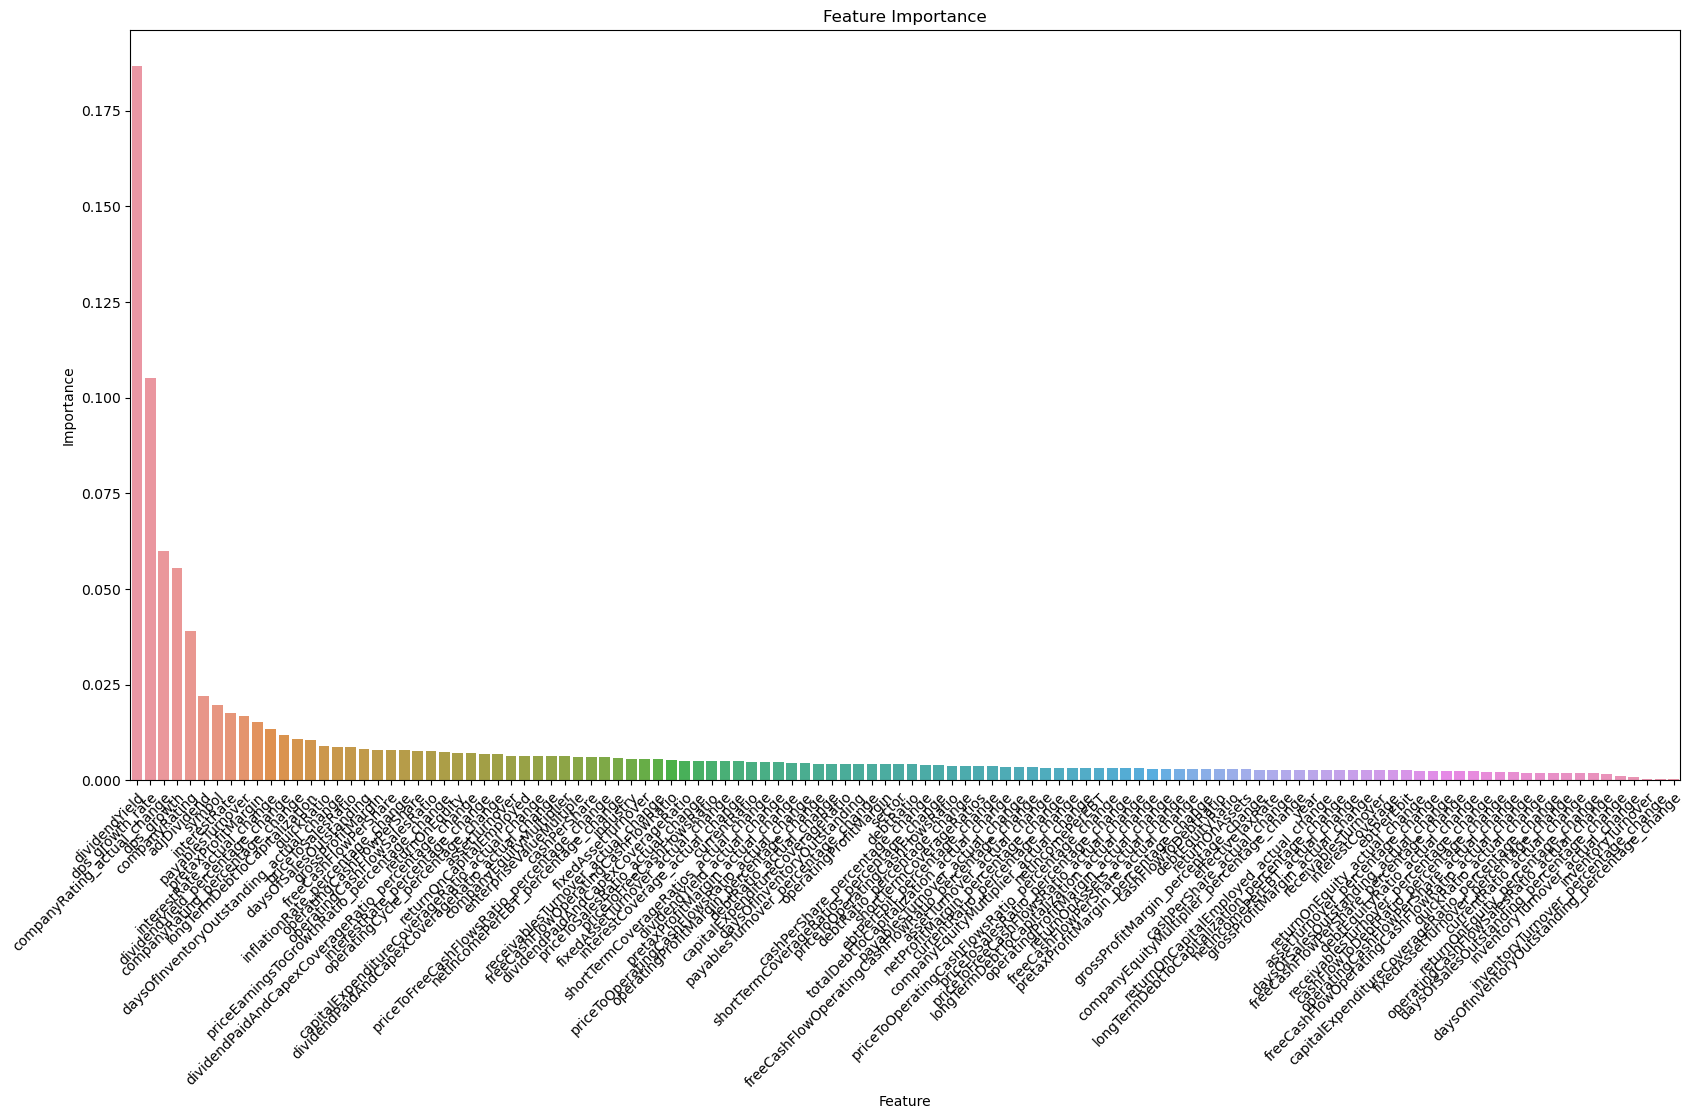

In [ ]:
# Feature importance analysis - Tree Based
randomForestModel = RandomForestClassifier(max_features=None)  # We want all features to be considered for each tree
randomForestModel.fit(X_train_oversampled, y_train_oversampled)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train_oversampled.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train_oversampled.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table.sort_values('Importance', inplace=True, ascending=False)


# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig('feature.png')
plt.show()

In [ ]:
# Sort features by importance in descending order
importance_table.sort_values(by='Importance', ascending=False, inplace=True)

# Calculate cumulative importance
importance_table['Cumulative Importance'] = importance_table['Importance'].cumsum()

# Find the last acceptable feature (where cumulative importance is just at or above 60%)
cutoff_index = importance_table[importance_table['Cumulative Importance'] <= 0.60].last_valid_index()

# If there is no such index, adjust the percentage criteria or take all features
if cutoff_index is None:
    selected_features = importance_table['Feature'].tolist()
else:
    selected_features = importance_table.loc[:cutoff_index, 'Feature'].tolist()

# Selected features are those that contribute to the top 60% of importance scores
print("Selected Features:", selected_features)

Selected Features: ['dividendYield', 'dps_growth_rate', 'companyRating_actual_change', 'dps_growth', 'companyRating', 'adjDividend', 'symbol', 'interestRate', 'payablesTurnover', 'interestRate_actual_change', 'dividendYield_percentage_change', 'pretaxProfitMargin', 'longTermDebtToCapitalization', 'companyRating_percentage_change', 'grossProfitMargin', 'operatingCashFlowPerShare', 'priceToSalesRatio', 'freeCashFlowPerShare', 'inflationRate_percentage_change', 'quickRatio', 'returnOnEquity', 'daysOfSalesOutstanding', 'operatingCycle_percentage_change', 'daysOfInventoryOutstanding_actual_change', 'operatingCashFlowSalesRatio', 'interestRate_percentage_change', 'priceEarningsToGrowthRatio_percentage_change', 'dividendPaidAndCapexCoverageRatio_percentage_change', 'enterpriseValueMultiple', 'assetTurnover', 'fixedAssetTurnover', 'companyEquityMultiplier', 'capitalExpenditureCoverageRatio_actual_change', 'industry', 'dividendPaidAndCapexCoverageRatio_actual_change', 'priceToFreeCashFlowsRatio

#Feature Engineering(PCA)

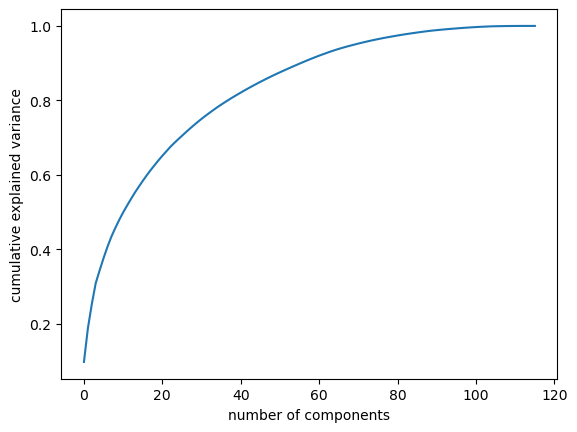

In [ ]:
X_train_oversampled = X_train_oversampled[selected_features]
X_test_transformed = X_test_transformed[selected_features]

# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_oversampled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

pca = PCA(n_components = 0.95)

X_train_final = pca.fit_transform(X_train_oversampled)
X_test_final = pca.transform(X_test_transformed)

explained_variance = pca.explained_variance_ratio_


#Model Training

##Logistic Regression

In [ ]:
# Simulate best_params_lr
best_params_lr = {"C": 1.0, "penalty": "l2"}

#Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)

# Define the directory and file path to save the model
model_dir = 'best_models'
model_file = os.path.join(model_dir, 'lr.pkl')

# If the directory does not exist, create the directory
os.makedirs(model_dir, exist_ok=True)

# Save model
with open(model_file, 'wb') as file:
     pickle.dump(best_model_lr, file)

In [ ]:
# Simulate best_params_lr
best_params_lr = {"C": 1.0, "penalty": "l2"}

#Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)

# Define the directory and file path to save the model
model_dir = 'best_models_fea+pca_rec0'
model_file = os.path.join(model_dir, 'lr.pkl')

# If the directory does not exist, create the directory
os.makedirs(model_dir, exist_ok=True)

# Save model
with open(model_file, 'wb') as file:
     pickle.dump(best_model_lr, file)

In [ ]:
# Bayesian Optimization with optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress log messages

# Logistic Regression
def objective_function(trial):
    C = trial.suggest_float('C', 0.1, 10, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver='liblinear',
        n_jobs=-1
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, C: {C}, penalty: {penalty}, ROC-AUC: {roc_auc}")
    return roc_auc


study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_function, n_trials=50)

best_params_lr = study_lr.best_params
print("Best Parameters: ", best_params_lr)
print("Best ROC-AUC Score: ", study_lr.best_value)

# Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)
with open('best_models/lr.pkl', 'wb') as file:
    pickle.dump(best_model_lr, file)

Trial 1, C: 0.22452475676836395, penalty: l1, ROC-AUC: 0.816816676650045
Trial 2, C: 6.900103303275947, penalty: l2, ROC-AUC: 0.8210231795893073
Trial 3, C: 0.1378747537709741, penalty: l1, ROC-AUC: 0.8153500276163583
Trial 4, C: 0.9905702930395847, penalty: l2, ROC-AUC: 0.8195534188532859
Trial 5, C: 0.29463612235685416, penalty: l2, ROC-AUC: 0.8176755064943821
Trial 6, C: 0.3260321052753592, penalty: l2, ROC-AUC: 0.8178507990592288
Trial 7, C: 4.780133868964029, penalty: l2, ROC-AUC: 0.8208224747887284
Trial 8, C: 0.7762440222401865, penalty: l2, ROC-AUC: 0.8192645491532279
Trial 9, C: 2.033937568546728, penalty: l1, ROC-AUC: 0.820477075829593
Trial 10, C: 0.21195309347095795, penalty: l2, ROC-AUC: 0.8172253468899833
Trial 11, C: 9.448939850349495, penalty: l1, ROC-AUC: 0.8214422221703603
Trial 12, C: 8.590315186999643, penalty: l1, ROC-AUC: 0.8214365173827473
Trial 13, C: 9.420642551304493, penalty: l1, ROC-AUC: 0.8214468897238623
Trial 14, C: 3.083861415802458, penalty: l1, ROC-AUC

##Decision Tree

In [ ]:


# Decision Tree
def objective_function(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, "
          f"min_samples_leaf: {min_samples_leaf}, criterion: {criterion}, ROC-AUC: {roc_auc}")
    return roc_auc

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_function, n_trials=50)

best_params_dt = study_dt.best_params
print("Best Parameters: ", best_params_dt)
print("Best ROC-AUC Score: ", study_dt.best_value)

# Create and save model
best_model_dt = DecisionTreeClassifier(**best_params_dt)
with open('best_models/dt.pkl', 'wb') as file:
    pickle.dump(best_model_dt, file)



Trial 1, max_depth: 6, min_samples_split: 7, min_samples_leaf: 11, criterion: gini, ROC-AUC: 0.8091764101846017
Trial 2, max_depth: 38, min_samples_split: 4, min_samples_leaf: 2, criterion: gini, ROC-AUC: 0.8341530075899606
Trial 3, max_depth: 38, min_samples_split: 15, min_samples_leaf: 11, criterion: gini, ROC-AUC: 0.8551961539359144
Trial 4, max_depth: 10, min_samples_split: 7, min_samples_leaf: 1, criterion: entropy, ROC-AUC: 0.8360506273969832
Trial 5, max_depth: 14, min_samples_split: 6, min_samples_leaf: 4, criterion: entropy, ROC-AUC: 0.8449210535186872
Trial 6, max_depth: 41, min_samples_split: 8, min_samples_leaf: 11, criterion: entropy, ROC-AUC: 0.8578047977263829
Trial 7, max_depth: 25, min_samples_split: 3, min_samples_leaf: 5, criterion: gini, ROC-AUC: 0.8446272569565995
Trial 8, max_depth: 8, min_samples_split: 3, min_samples_leaf: 7, criterion: entropy, ROC-AUC: 0.836397582207286
Trial 9, max_depth: 21, min_samples_split: 14, min_samples_leaf: 8, criterion: entropy, ROC

##KNN

In [ ]:
# KNN
def objective_function(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        metric=metric
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, n_neighbors: {n_neighbors}, weights: {weights}, p: {p}, metric: {metric}, "
          f"ROC-AUC: {roc_auc}")
    return roc_auc


study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_function, n_trials=50)

best_params_knn = study_knn.best_params
print("Best Parameters: ", best_params_knn)
print("Best ROC-AUC Score: ", study_knn.best_value)

# Create and save model
best_model_knn = KNeighborsClassifier(**best_params_knn)
with open('best_models/knn.pkl', 'wb') as file:
    pickle.dump(best_model_knn, file)

Trial 1, n_neighbors: 30, weights: distance, p: 1, metric: manhattan, ROC-AUC: 0.9515007481051029
Trial 2, n_neighbors: 30, weights: uniform, p: 4, metric: euclidean, ROC-AUC: 0.9132561112537309
Trial 3, n_neighbors: 17, weights: uniform, p: 3, metric: euclidean, ROC-AUC: 0.9433618313405473
Trial 4, n_neighbors: 14, weights: uniform, p: 1, metric: euclidean, ROC-AUC: 0.9495875697864076
Trial 5, n_neighbors: 8, weights: distance, p: 4, metric: minkowski, ROC-AUC: 0.95080528263333
Trial 6, n_neighbors: 29, weights: distance, p: 5, metric: manhattan, ROC-AUC: 0.9529313532534143
Trial 7, n_neighbors: 9, weights: distance, p: 1, metric: minkowski, ROC-AUC: 0.9668251041772011
Trial 8, n_neighbors: 23, weights: uniform, p: 3, metric: minkowski, ROC-AUC: 0.9153004996875331
Trial 9, n_neighbors: 26, weights: uniform, p: 4, metric: manhattan, ROC-AUC: 0.9317121364170304
Trial 10, n_neighbors: 23, weights: distance, p: 2, metric: minkowski, ROC-AUC: 0.9526927894077651
Trial 11, n_neighbors: 2, we

##Random Forest

In [ ]:
# Random Forest
def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, n_estimators: {n_estimators}, max_depth: {max_depth}, "
          f"min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, ROC-AUC: {roc_auc}")
    return roc_auc


study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_function, n_trials=50)

best_params_rf = study_rf.best_params
print("Best Parameters: ", best_params_rf)
print("Best ROC-AUC: Score: ", study_rf.best_value)

# Create and save model
best_model_rf = RandomForestClassifier(**best_params_rf, n_jobs=-1)
with open('best_models/rf.pkl', 'wb') as file:
    pickle.dump(best_model_rf, file)


Trial 1, n_estimators: 17, max_depth: 7, min_samples_split: 4, min_samples_leaf: 11, ROC-AUC: 0.910095140298879
Trial 2, n_estimators: 140, max_depth: 24, min_samples_split: 12, min_samples_leaf: 8, ROC-AUC: 0.9700768331168108
Trial 3, n_estimators: 23, max_depth: 24, min_samples_split: 14, min_samples_leaf: 4, ROC-AUC: 0.9667556094917293
Trial 4, n_estimators: 113, max_depth: 38, min_samples_split: 13, min_samples_leaf: 3, ROC-AUC: 0.9770926846471198
Trial 5, n_estimators: 30, max_depth: 47, min_samples_split: 15, min_samples_leaf: 15, ROC-AUC: 0.9490251295894367
Trial 6, n_estimators: 77, max_depth: 21, min_samples_split: 13, min_samples_leaf: 3, ROC-AUC: 0.9760030702129701
Trial 7, n_estimators: 139, max_depth: 37, min_samples_split: 8, min_samples_leaf: 8, ROC-AUC: 0.9689327638918062
Trial 8, n_estimators: 87, max_depth: 50, min_samples_split: 3, min_samples_leaf: 7, ROC-AUC: 0.9706545725169263
Trial 9, n_estimators: 54, max_depth: 18, min_samples_split: 8, min_samples_leaf: 2, ROC

##XgBoost

In [ ]:
# XgBoost
# It requires the target to be 0 and 1, and all features be numerical
# Encode our target
label_encoder = LabelEncoder()
# Fit the encoder and transform the target variable
y_train_oversampled_encoded = label_encoder.fit_transform(y_train_oversampled)


# This suppresses printing logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.9, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        use_label_encoder=False,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled_encoded, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number+1}, n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate},"
          f"min_child_weight: {min_child_weight}, subsample: {subsample}, colsample_bytree: {colsample_bytree}, "
          f"gamma: {gamma}, reg_alpha: {reg_alpha}, reg_lambda: {reg_lambda}, ROC-AUC: {roc_auc}")
    return roc_auc


study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_function, n_trials=50)

best_params_xgb = study_xgb.best_params
print("Best Parameters: ", best_params_xgb)
print("Best ROC-AUC Score: ", study_xgb.best_value)

best_model_xgb = XGBClassifier(**best_params_xgb, use_label_encoder=False, n_jobs=-1)
with open('best_models/xgb.pkl', 'wb') as file:
    pickle.dump(best_model_xgb, file)


Trial 1, n_estimators: 134, max_depth: 46, learning_rate: 0.4871879732714302,min_child_weight: 1, subsample: 0.7742272548969249, colsample_bytree: 0.5740215095174981, gamma: 0.6852623553486134, reg_alpha: 0.4528969788615518, reg_lambda: 0.9497646247838009, ROC-AUC: 0.9720828438884869
Trial 2, n_estimators: 110, max_depth: 9, learning_rate: 0.0012971569472842194,min_child_weight: 7, subsample: 0.7125773000726454, colsample_bytree: 0.6918890610443733, gamma: 0.36248035376814747, reg_alpha: 0.25250469635029404, reg_lambda: 0.8862646124979818, ROC-AUC: 0.9355312324156404
Trial 3, n_estimators: 31, max_depth: 9, learning_rate: 0.010464227175494457,min_child_weight: 3, subsample: 0.8083355094357882, colsample_bytree: 0.7321142016850231, gamma: 0.6536097715021932, reg_alpha: 0.8135242008573667, reg_lambda: 0.38073711336549043, ROC-AUC: 0.9496931083572544
Trial 4, n_estimators: 62, max_depth: 41, learning_rate: 0.04700703674534423,min_child_weight: 2, subsample: 0.6799804529036664, colsample_b

Trial 30, n_estimators: 135, max_depth: 14, learning_rate: 0.029386186881183333,min_child_weight: 1, subsample: 0.7415014901184347, colsample_bytree: 0.560675422336373, gamma: 0.6176080363046903, reg_alpha: 0.514200400190648, reg_lambda: 0.8826315696913272, ROC-AUC: 0.9821958764757897
Trial 31, n_estimators: 150, max_depth: 6, learning_rate: 0.01243932438001379,min_child_weight: 3, subsample: 0.651505794707881, colsample_bytree: 0.5202586560018927, gamma: 0.7136883286886915, reg_alpha: 0.6957107526244986, reg_lambda: 0.8766152728282519, ROC-AUC: 0.9417676025111437
Trial 32, n_estimators: 124, max_depth: 27, learning_rate: 0.08543480493876879,min_child_weight: 1, subsample: 0.574650611995734, colsample_bytree: 0.8164175810049678, gamma: 0.2630096959260182, reg_alpha: 0.9945513691628296, reg_lambda: 0.7587436488072729, ROC-AUC: 0.9835110893291947
Trial 33, n_estimators: 118, max_depth: 27, learning_rate: 0.09308142825947036,min_child_weight: 1, subsample: 0.5786168027303606, colsample_by

#Model Selection

In [ ]:
# Model selection - Compare Performance
with open('best_models/lr.pkl', 'rb') as file:
    best_model_lr = pickle.load(file)
with open('best_models/dt.pkl', 'rb') as file:
    best_model_dt = pickle.load(file)
with open('best_models/knn.pkl', 'rb') as file:
    best_model_knn = pickle.load(file)
with open('best_models/rf.pkl', 'rb') as file:
    best_model_rf = pickle.load(file)
with open('best_models/xgb.pkl', 'rb') as file:
    best_model_xgb = pickle.load(file)

In [ ]:
def evaluate_models(models, X_train, y_train, X_test, y_test):
    """
    Evaluates multiple models by fitting them on training data, predicting probabilities on test data,
    comparing predicted results with actual results, and computing the ROC AUC score for each.

    Parameters:
    - models: dict, a dictionary of models where keys are model names and values are the model instances.
    - X_train: array-like, training features.
    - y_train: array-like, training target.
    - X_test: array-like, testing features.
    - y_test: array-like, testing target.

    Returns:
    - result_df: DataFrame, a DataFrame containing actual values, predicted probabilities and model comparisons.
    """
    predictions = {'Actual': y_test}
    performances = {}
    print("Testing Performances...Please wait")

    for model_name, model in models.items():
      if model_name == 'XGBoost':
        # Fit and transform the labels in the training data
        y_train = label_encoder.fit_transform(y_train)

        # Transform the labels in the test data
        y_test = label_encoder.transform(y_test)
      else:
        # Fit the model
        model.fit(X_train, y_train)

      # Predict probabilities
      predicted_probs = model.predict_proba(X_test)[:, 1]
      predictions[f'Predicted_Prob_{model_name}'] = predicted_probs

      # Compute ROC AUC score
      roc_auc = roc_auc_score(y_test, predicted_probs)
      performances[model_name] = roc_auc
      print(f"{model_name} ROC AUC: {roc_auc:.4f}")

    # Create a DataFrame from the predictions dictionary
    result_df = pd.DataFrame(predictions)

    # Add a summary of performances at the end of the DataFrame
    performance_summary = pd.DataFrame([performances], index=['ROC AUC Score'])

    return result_df, performance_summary

# Example usage:
models = {
    'Logistic Regression': best_model_lr,
    'Decision Tree': best_model_dt,
    'KNN': best_model_knn,
    'Random Forest': best_model_rf,
    'XGBoost': best_model_xgb
}

# Assuming X_train_final, y_train_oversampled, X_test_final, y_test are already defined and prepared
prediction_results, performance_summary = evaluate_models(models, X_train_final, y_train_oversampled, X_test_final, y_test)



Testing Performances...Please wait
Logistic Regression ROC AUC: 0.9624
Decision Tree ROC AUC: 0.5446
KNN ROC AUC: 0.6916
Random Forest ROC AUC: 0.3818


In [ ]:
prediction_results.to_csv('prediction.csv', index=False)

prediction_results

,Actual,Predicted_Prob_Logistic Regression,Predicted_Prob_Decision Tree,Predicted_Prob_KNN,Predicted_Prob_Random Forest
9,constant/increased,0.0058,0.6667,0.0000,0.3468
10,decreased,0.9155,1.0000,0.5388,0.4916
20,constant/increased,0.0012,0.0000,0.3838,0.3088
21,decreased,0.8840,0.0000,0.7685,0.2506
31,constant/increased,0.0008,0.0000,0.0000,0.2989
32,decreased,0.7327,0.7778,0.6154,0.2877
42,constant/increased,0.0019,0.0000,0.0000,0.2714
43,decreased,0.7514,0.0000,0.2271,0.2922
53,constant/increased,0.0004,0.0000,0.2298,0.2497
54,decreased,0.3977,0.0000,0.6116,0.1241


In [ ]:
# Define the path to save the file on the desktop
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')

# Save the filtered data back to a CSV file on the desktop
prediction_results.to_csv(os.path.join(desktop_path, 'prediction.csv'), index=False)

print("Filtered CSV file has been saved to your desktop.")

Filtered CSV file has been saved to your desktop.
